In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

Create the dataset

Text(0, 0.5, 'y values (output)')

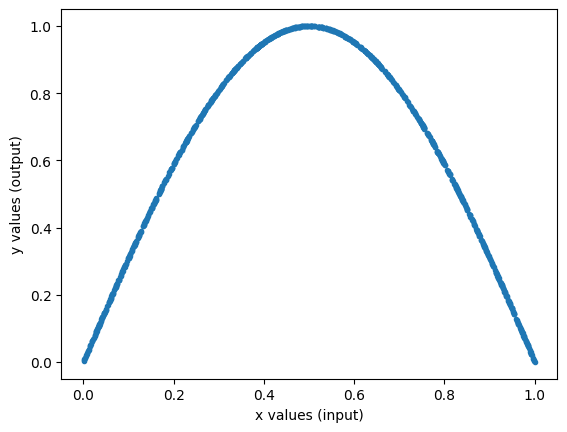

In [ ]:
num_sample = 1000
x = np.random.uniform(low=0, high=1, size=num_sample).astype(np.float32)
# Shuffle the values to guarantee they're not in order
np.random.shuffle(x)
y = np.sin(math.pi*x).astype(np.float32)
plt.plot(x, y, '.')
plt.xlabel('x values (input)')
plt.ylabel('y values (output)')

Add random noise to look the data realistic

Text(0, 0.5, 'y values (output noisy)')

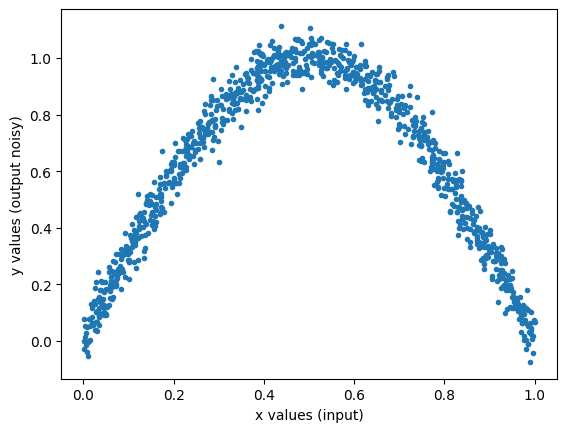

In [ ]:
# Add a small random number to y 
y= y+ 0.05 * np.random.randn(*y.shape)
plt.plot(x, y, '.')
plt.xlabel('x values (input)')
plt.ylabel('y values (output noisy)')


Split between training and test data

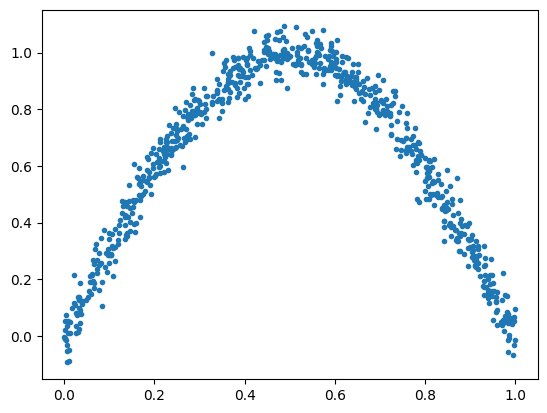

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75)
plt.plot(x_train, y_train, '.')

Define the neural network

In [ ]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(1,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='adam', loss='mean_squared_error')

Training

In [ ]:
history = model.fit(x_train, y_train, epochs=500, batch_size=50,validation_data=(x_test, y_test))

Epoch 1/500
15/15 [==============================] - 1s 16ms/step - loss: 0.5211 - val_loss: 0.4899
Epoch 2/500
15/15 [==============================] - 0s 4ms/step - loss: 0.3940 - val_loss: 0.3690
Epoch 3/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2931 - val_loss: 0.2784
Epoch 4/500
15/15 [==============================] - 0s 4ms/step - loss: 0.2246 - val_loss: 0.2183
Epoch 5/500
15/15 [==============================] - 0s 4ms/step - loss: 0.1728 - val_loss: 0.1668
Epoch 6/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1380 - val_loss: 0.1369
Epoch 7/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1213 - val_loss: 0.1237
Epoch 8/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1152 - val_loss: 0.1181
Epoch 9/500
15/15 [==============================] - 0s 4ms/step - loss: 0.1119 - val_loss: 0.1146
Epoch 10/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1088 - val_loss: 0.1116
Epoch 11

Evaluate the model

8/8 [==============================] - 0s 2ms/step


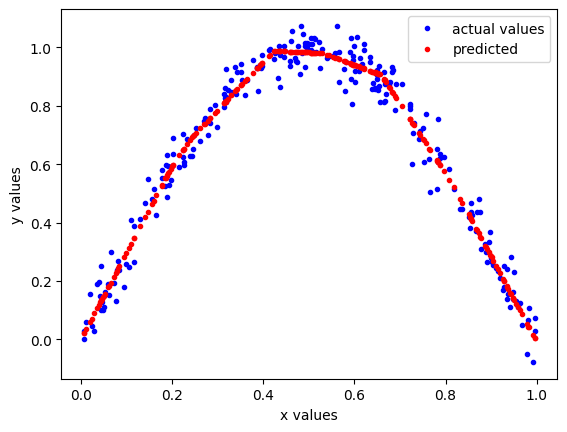

In [ ]:
test_loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.plot(x_test, y_test, 'b.', label='actual values')
plt.plot(x_test, y_test_pred, 'r.', label='predicted')
plt.legend()
plt.xlabel('x values')
plt.ylabel('y values')
plt.show()

Convert to TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

import pathlib

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(model_no_quant_tflite)

2588

Evaluate the TFLite model

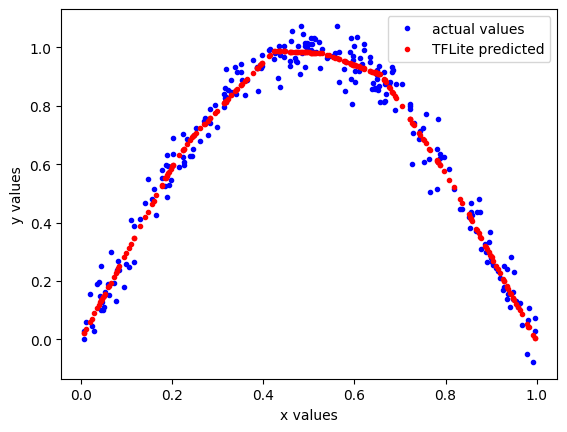

In [ ]:
tflite_model_file = 'tflite_models/model.tflite'
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

prediction_list = []

x_test = x_test.reshape((x_test.size, 1))
x_test = x_test.astype(np.float32)

for i in range (len(x_test)):
  interpreter.set_tensor(input_index, [x_test[i]])
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)[0]
  prediction_list.append(prediction)

plt.clf()
plt.plot(x_test, y_test, 'b.', label='actual values')
plt.plot(x_test, np.array(prediction_list), 'r.', label='TFLite predicted')
plt.legend()
plt.xlabel('x values')
plt.ylabel('y values')
plt.show()

Convert the TFLite model into an equivalent C library for Arduino 

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i tflite_models/model.tflite > model.cc

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,150 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,334 kB]
Fetched 4,823 kB i